In [1]:
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

### Labels
anger = Wut
boredom = Langeweile
anxiety = Angst
happiness = Freude
sadness = Traurig
disgust = Ekel
neutral = neutral

### Create Dataset

In [2]:
df = pd.DataFrame(columns=["Emotion", "Path"])

In [3]:
row_list = list()
files = glob.glob("../data/wav/*.wav")
for file in files:
    emotion_label = ""
    
    if "W" in file:
        emotion_label = "anger"
    elif "L" in file:
        emotion_label = "boredom"
    elif "A" in file:
        emotion_label = "anxiety"
    elif "F" in file:
        emotion_label = "happiness"
    elif "T" in file:
        emotion_label = "sadness"
    elif "E" in file:
        emotion_label = "disgust"
    elif "N" in file:
        emotion_label = "neutral"
        
    row_list.append({"Emotion": emotion_label, "Path": file})
        
df = pd.DataFrame(row_list)

In [4]:
df.head()

,Emotion,Path
0,happiness,../data/wav\03a01Fa.wav
1,neutral,../data/wav\03a01Nc.wav
2,anger,../data/wav\03a01Wa.wav
3,happiness,../data/wav\03a02Fc.wav
4,neutral,../data/wav\03a02Nc.wav


### Feature Engineering

In [5]:
audio_data, sampling_rate = librosa.load(df.iloc[0].Path)

#### Spectrogram

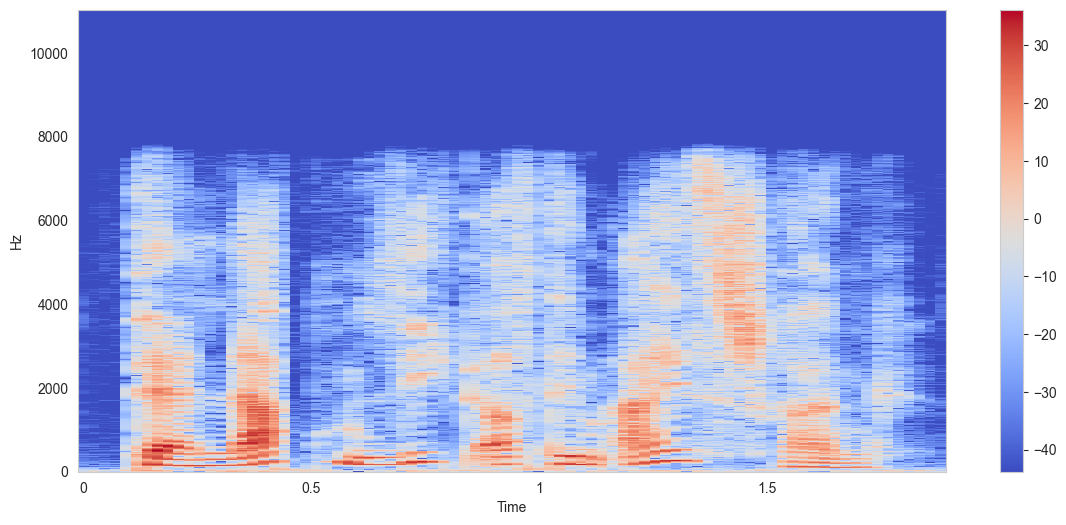

In [6]:
stft = librosa.stft(audio_data)
stft_db = librosa.amplitude_to_db(abs(stft))

plt.figure(figsize=(14, 6))
librosa.display.specshow(stft_db, sr=sampling_rate, x_axis="time", y_axis="hz")
plt.colorbar()
plt.show()

#### Zero crossing rate

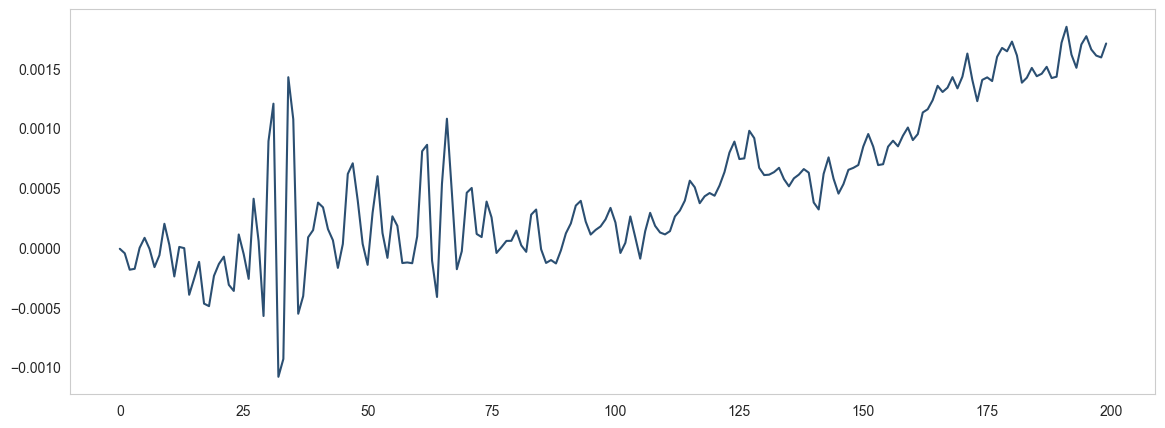

In [7]:
start = 1000
end = 1200
plt.figure(figsize=(14, 5))
plt.plot(audio_data[start:end], color="#2B4F72")
plt.grid()

In [8]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [9]:
def extract_features(data, sample_rate):
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))
    
    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    
    return result

In [10]:
def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # Without AUGMENTATION
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # Data with NOISE
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # Data with NOISE is distinct from data with STRETCHING and PITCHING
    
    # Data with STRETCHING and PITCHING
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [11]:
X, y = list(), list()

for i, row in df.iterrows():
    feature = get_features(row.Path)
    if i % 10 == 0:
        print("Import Data: RUNNING ... {} files".format(i))

    for f in feature:
        X.append(f)
        y.append(row.Emotion)
    
print(len(X))
print(len(y))

audio_features = pd.DataFrame(X)
audio_features["labels"] = y

Import Data: RUNNING ... 0 files
Import Data: RUNNING ... 10 files
Import Data: RUNNING ... 20 files
Import Data: RUNNING ... 30 files
Import Data: RUNNING ... 40 files
Import Data: RUNNING ... 50 files
Import Data: RUNNING ... 60 files
Import Data: RUNNING ... 70 files
Import Data: RUNNING ... 80 files
Import Data: RUNNING ... 90 files
Import Data: RUNNING ... 100 files
Import Data: RUNNING ... 110 files
Import Data: RUNNING ... 120 files
Import Data: RUNNING ... 130 files
Import Data: RUNNING ... 140 files
Import Data: RUNNING ... 150 files
Import Data: RUNNING ... 160 files
Import Data: RUNNING ... 170 files
Import Data: RUNNING ... 180 files
Import Data: RUNNING ... 190 files
Import Data: RUNNING ... 200 files
Import Data: RUNNING ... 210 files
Import Data: RUNNING ... 220 files
Import Data: RUNNING ... 230 files
Import Data: RUNNING ... 240 files
Import Data: RUNNING ... 250 files
Import Data: RUNNING ... 260 files
Import Data: RUNNING ... 270 files
Import Data: RUNNING ... 280 fi

In [12]:
audio_features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.115618,0.499997,0.458973,0.467132,0.533155,0.611216,0.681722,0.637542,0.640213,0.638196,...,3.539495e-07,3.281289e-07,3.097139e-07,2.959580e-07,2.856773e-07,2.782837e-07,2.728936e-07,2.694105e-07,2.672512e-07,happiness
1,0.191833,0.556659,0.537390,0.577308,0.636179,0.719348,0.705824,0.668121,0.665124,0.660115,...,1.457414e-03,1.484801e-03,1.341261e-03,1.334499e-03,1.402466e-03,1.477746e-03,1.405244e-03,1.400673e-03,1.402875e-03,happiness
2,0.132575,0.522431,0.489791,0.463504,0.489769,0.582250,0.683932,0.683347,0.662388,0.648336,...,2.605095e-07,2.271940e-07,2.047578e-07,1.885742e-07,1.767617e-07,1.686012e-07,1.637054e-07,1.305584e-07,5.106658e-08,happiness
3,0.085127,0.642731,0.575785,0.654186,0.695828,0.723245,0.746221,0.702634,0.706903,0.706644,...,2.302637e-09,2.158271e-09,2.055215e-09,1.977964e-09,1.920246e-09,1.879111e-09,1.849288e-09,1.830329e-09,1.818177e-09,neutral
4,0.263738,0.746258,0.691044,0.746294,0.801561,0.805549,0.774332,0.733975,0.725383,0.720349,...,1.094790e-02,1.062383e-02,1.086707e-02,1.204796e-02,1.137310e-02,1.183050e-02,1.255251e-02,1.042373e-02,1.157573e-02,neutral


In [23]:
X = audio_features.iloc[: ,:-1].values
y = audio_features["labels"].values

encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1, 1)).toarray()

print(X.shape)
print(y.shape)

(1605, 162)
(1605, 7)


In [24]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1203, 162)
(1203, 7)
(402, 162)
(402, 7)


### Create Model

In [15]:
EPOCHS = 150

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation="relu", input_shape=(x_train.shape[1],)),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(128, activation="relu"),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               41728     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 58,631
Trainable params: 58,631
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [18]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=EPOCHS, batch_size=32)

Epoch 1/150
38/38 [==============================] - 1s 7ms/step - loss: 9.2538 - accuracy: 0.2527 - val_loss: 1.5833 - val_accuracy: 0.4403
Epoch 2/150
38/38 [==============================] - 0s 3ms/step - loss: 2.3180 - accuracy: 0.3250 - val_loss: 1.6666 - val_accuracy: 0.3483
Epoch 3/150
38/38 [==============================] - 0s 3ms/step - loss: 1.7393 - accuracy: 0.3599 - val_loss: 1.4762 - val_accuracy: 0.4279
Epoch 4/150
38/38 [==============================] - 0s 3ms/step - loss: 1.6531 - accuracy: 0.3865 - val_loss: 1.4592 - val_accuracy: 0.4055
Epoch 5/150
38/38 [==============================] - 0s 3ms/step - loss: 1.5757 - accuracy: 0.3749 - val_loss: 1.3684 - val_accuracy: 0.4428
Epoch 6/150
38/38 [==============================] - 0s 3ms/step - loss: 1.5291 - accuracy: 0.4165 - val_loss: 1.3282 - val_accuracy: 0.4353
Epoch 7/150
38/38 [==============================] - 0s 3ms/step - loss: 1.4550 - accuracy: 0.4314 - val_loss: 1.2458 - val_accuracy: 0.4826
Epoch 8/150
3

13/13 [==============================] - 0s 1ms/step - loss: 0.7809 - accuracy: 0.8682
Accuracy of the model on test data : 86.81591749191284 %


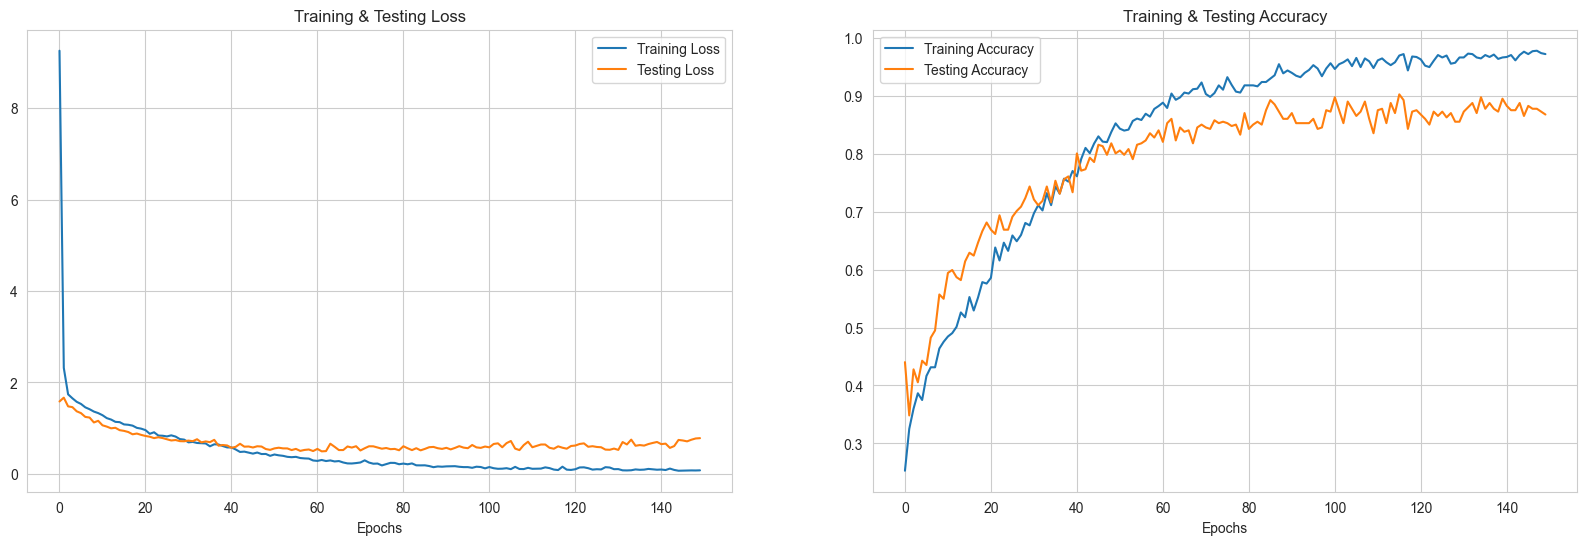

In [19]:
print(f"Accuracy of the model on test data : {model.evaluate(x_test, y_test)[1] * 100} %")

epochs = [i for i in range(EPOCHS)]

fig , ax = plt.subplots(1, 2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
test_acc = history.history["val_accuracy"]
test_loss = history.history["val_loss"]

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label="Training Loss")
ax[0].plot(epochs, test_loss , label="Testing Loss")
ax[0].set_title("Training & Testing Loss")
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label="Training Accuracy")
ax[1].plot(epochs, test_acc, label="Testing Accuracy")
ax[1].set_title("Training & Testing Accuracy")
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [25]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test_inverse = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test_inverse.flatten()

df.head(10)

13/13 [==============================] - 0s 1ms/step


,Predicted Labels,Actual Labels
0,boredom,boredom
1,anxiety,disgust
2,anxiety,anxiety
3,neutral,neutral
4,anger,anger
5,neutral,neutral
6,boredom,boredom
7,disgust,happiness
8,anger,anger
9,anger,anger


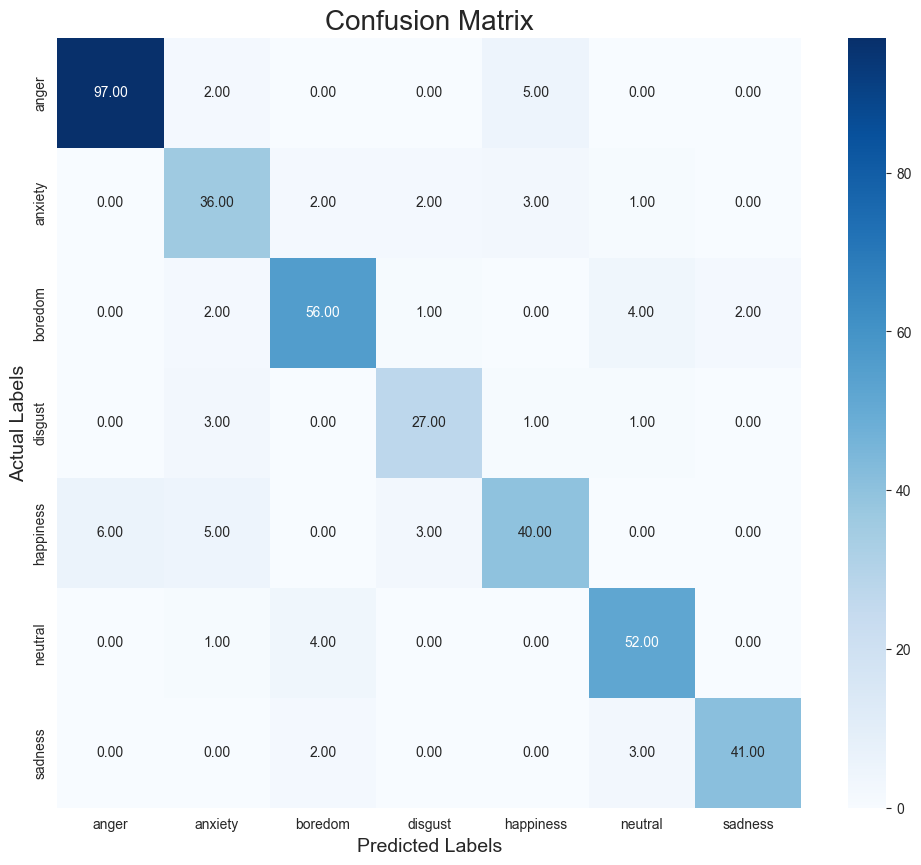

              precision    recall  f1-score   support

       anger       0.94      0.93      0.94       104
     anxiety       0.73      0.82      0.77        44
     boredom       0.88      0.86      0.87        65
     disgust       0.82      0.84      0.83        32
   happiness       0.82      0.74      0.78        54
     neutral       0.85      0.91      0.88        57
     sadness       0.95      0.89      0.92        46

    accuracy                           0.87       402
   macro avg       0.86      0.86      0.86       402
weighted avg       0.87      0.87      0.87       402


In [36]:
cm = confusion_matrix(y_test_inverse, y_pred)
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])

plt.figure(figsize = (12, 10))
sns.heatmap(cm, annot=True, cmap="Blues",  fmt=".2f")
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

print(classification_report(y_test_inverse, y_pred))